In [1]:
import pandas as pd
import numpy as np
import mplleaflet as mpl
import matplotlib.pyplot as plt
from pymove import trajutils, maputils, semantic
from tqdm import tqdm_notebook as tqd
import time

# 1. Read and presentation of the data 

### 1.1 Read dataset

In [10]:
lib_read_csv = 0  #0 -- 'pandas', #1 -- 'dask', #2 -- 'modin
filename = '/Users/nickssonarrais/datasets/tnz/raw/tnz2019_05_599.csv.gz'
usecols=[0, 1, 2, 3]

##### Get number of rows in the file

In [12]:
compression = filename.split('.')[-1]
n_rows = ''
if compression == 'gz':
    n_rows = !zcat {filename} | wc -l
    compression = 'gzip'
elif compression == 'zip':
    n_rows = !zcat {filename} | wc -l
elif compression == 'csv':
    n_rows = !cat {filename} | wc -l

#n_rows = int(n_rows[0])
print("rows: {}".format(n_rows))

rows: ["zcat: can't stat: /Users/nickssonarrais/datasets/tnz/raw/tnz2019_05_599.csv.gz (/Users/nickssonarrais/datasets/tnz/raw/tnz2019_05_599.csv.gz.Z): No such file or directory", '       0']


In [13]:
if compression == 'csv':
    !head {filename}
    compression = None
elif compression == 'gzip':
    !gzip -cd {filename} | head

id,datetime,lat,lon
M80001,2019-06-01 00:00:54,-3.79239,-38.593379999999996
M80001,2019-06-01 00:01:54,-3.79239,-38.593379999999996
M80001,2019-06-01 00:02:54,-3.7923699999999996,-38.59336
M80001,2019-06-01 00:03:54,-3.7924,-38.593379999999996
M80001,2019-06-01 00:04:54,-3.79244,-38.593379999999996
M80001,2019-06-01 00:05:54,-3.79238,-38.59336
M80001,2019-06-01 00:06:54,-3.79238,-38.59336
M80001,2019-06-01 00:07:54,-3.79238,-38.59336
M80001,2019-06-01 00:08:54,-3.79238,-38.59336
gzip: error writing to output: Broken pipe
gzip: /Users/nickssonarrais/datasets/tnz/raw/tnz2019_05_599.csv.gz: uncompress failed


In [21]:
names = ['id', 'datetime', 'lat', 'lon']
dtype = {'lat':'float32', 'lon':'float32'}
parse_dates= [1]
header=1
usecols=[0, 1, 2, 3]

###### Read CSV

In [22]:
%%time
if lib_read_csv == 0:
    df = pd.read_csv(filename, names=names, dtype=dtype, header=header, compression=compression, usecols=usecols, parse_dates=parse_dates)
#elif lib_read_csv == 1: 
#    df = dd.read_csv(filename, names=names, dtype=dtype, header=header, compression=compression, usecols=usecols, parse_dates=parse_dates)
#elif lib_read_csv == 2:
#    df = mp.read_csv(filename, names=names, dtype=dtype, header=header, compression=compression, usecols=usecols, parse_dates=parse_dates)  

CPU times: user 32.2 s, sys: 1.74 s, total: 33.9 s
Wall time: 33.9 s


#### Sort Values

In [23]:
%%time
df.sort_values(['id', 'datetime'], inplace=True)

CPU times: user 12.2 s, sys: 2.68 s, total: 14.9 s
Wall time: 14.5 s


In [25]:
df.head()

,id,datetime,lat,lon
0,M80001,2019-06-01 00:01:54,-3.79239,-38.593380
1,M80001,2019-06-01 00:02:54,-3.79237,-38.593361
2,M80001,2019-06-01 00:03:54,-3.79240,-38.593380
3,M80001,2019-06-01 00:04:54,-3.79244,-38.593380
4,M80001,2019-06-01 00:05:54,-3.79238,-38.593361


## 1.2 Show Data

###### General information

In [26]:
trajutils.show_trajectories_info(df)


======================= INFORMATION ABOUT DATASET =======================

Number of Points: 22570857

Number of IDs objects: 599

Start Date:2019-06-01 00:00:00     End Date:2019-06-30 23:59:50

Bounding Box:(-25.56655, -49.34667, -2.52435, -37.76569)





##### Information about dataset dtypes

In [27]:
df.head()

,id,datetime,lat,lon
0,M80001,2019-06-01 00:01:54,-3.79239,-38.593380
1,M80001,2019-06-01 00:02:54,-3.79237,-38.593361
2,M80001,2019-06-01 00:03:54,-3.79240,-38.593380
3,M80001,2019-06-01 00:04:54,-3.79244,-38.593380
4,M80001,2019-06-01 00:05:54,-3.79238,-38.593361


In [28]:
trajutils.create_update_dist_time_speed_features(df)

Creating or updating distance, time and speed features in meters by seconds
...Sorting by id and datetime to increase performance
...Set id as index to a higher peformance
(42231/22570857) 0% in 00:00:17.979 - estimated end in 02:39:51.388
(4519952/22570857) 20% in 00:00:18.298 - estimated end in 00:01:13.076
(9041295/22570857) 40% in 00:00:18.594 - estimated end in 00:00:27.824
(13567467/22570857) 60% in 00:00:18.963 - estimated end in 00:00:12.583
(18067360/22570857) 80% in 00:00:19.266 - estimated end in 00:00:04.802
(22570857/22570857) 100% in 00:00:19.563 - estimated end in 00:00:00.000
...Reset index...

Total Time: 20.20 seconds
-----------------------------------------------------



In [111]:
df['id'].unique()[0:20]

array(['M60145', 'M60148', 'M60153', 'M60171', 'M60180', 'M60213',
       'M60233', 'M60239', 'M60281', 'M60394', 'M60421', 'M60445',
       'M60455', 'M60512', 'M60589', 'M60655', 'M60657', 'M60663',
       'M60766', 'M60767'], dtype=object)

In [38]:
filter_ = (df['id']== 'M79074') & (df['speed_to_prev'] > 10)
start=0
end=15
plt.plot(df[filter_].iloc[start:end]['lon'],df[filter_].iloc[start:end]['lat'], '-o')
plt.plot(df[filter_].iloc[start:end]['lon'],df[filter_].iloc[start:end]['lat'], 'ro')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
#plt.savefig('trajectory_example_line.png')

In [85]:
filter_2 = (df['speed_to_prev'] > 2000)

In [120]:
df = trajutils.filter_bbox(df, [-3.90, -38.67, -3.68, -38.38], inplace=True)

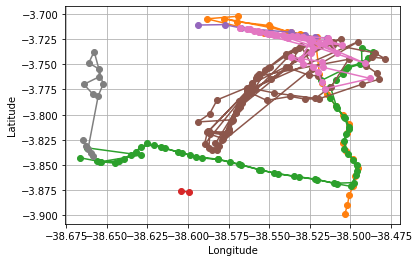

In [127]:
start=0
end=500
ids = df['id'].unique()[0:8] #['M74017', 'M76627', 'M79140','M79558']
for i in ids:
    filter_2 = (df['id']== i) & (df['speed_to_prev'] > 10)
    plt.plot(df[filter_2].iloc[start:end]['lon'],df[filter_2].iloc[start:end]['lat'], '-o')
    #plt.plot(df[filter_2].iloc[start:end]['lon'],df[filter_2].iloc[start:end]['lat'], 'ro')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
plt.savefig('trajectory_example_profiles_3.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
#filter_ = (df['id'] == 'M63708') & (df['speed_to_prev'] > 200) 
#df[filter_]

In [ ]:
df[filter_]['id'].unique()

In [ ]:
fig = maputils.show_traj(df[filter_], label_tid='id', figsize=(10,10),markersize=10,)

In [ ]:
mpl.show(fig)

# 2.  Data Cleaning

Creating a dicionary to store current state of the dataset

In [ ]:
dic_database = {}
dic_database['total size'] = df.shape[0]

### 2.1 Drop duplicates points GPS to each id
Since this data is captured by space-time requests, duplicate data may exist when there is more than one request

In [ ]:
subset = ['id', 'datetime']
trajutils.clean_duplicates(df, subset)
dic_database['rows duplicates'] = df.shape[0]

### 2.2 Drop consecutives duplicates by subset

In [ ]:
subset = ['lat','lon']
trajutils.clean_consecutive_duplicates(df, subset, inplace=True)
dic_database['consecutives duplicates'] = df.shape[0]

### 2.3 Drop filter Bbox points

In [ ]:
#bboxCeara = [-7.89, -41.45,-2.74, -37.18] # https://boundingbox.klokantech.com/
bbox_Fortaleza = [-3.90, -38.67, -3.68, -38.38]
#bbox_Total = [-4.379821, -41.00834, -2.88384, -38.38159]

In [ ]:
trajutils.filter_bbox(df, bbox_Fortaleza, inplace=True)
dic_database['bbox Ceará'] = df.shape[0]

In [ ]:
#maputils.show_lat_lon_GPS(df)

# 3. Segmentation trajectory to drop

In [ ]:
trajutils.create_update_dist_time_speed_features(df)

In [ ]:
%%time
trajutils.segment_traj_by_max_speed(df, max_speed_between_adj_points=50.0, update_features_by_segment=False)

In [ ]:
#df[df['tid_speed'] == 171]
df['tid_speed'].nunique()

In [ ]:
df.groupby(['id', 'tid_speed']).tid_speed.nunique().groupby(['id']).count().sort_values(ascending=False).head(20)
#.to_csv(file+'_anomalos_by_speed.csv')

In [ ]:
#df[df['id'] == 'M00536']

In [ ]:
#df[df['tid_speed'] == 16] # 2019-06-17 11:49:02

In [ ]:
df_aux, fig_ = maputils.show_traj_id(df, 17, label_tid='tid_speed')
mpl.show(fig_)

In [ ]:
#%%time
# dist = 3000m
# time = 7200s -> 2h
# speed = 50 m/s -> 180km/h
#trajutils.segment_trajectory_by_dist_time_speed(df, label_id='id', max_dist_between_adj_points=30000,
 #   max_time_between_adj_points=7200, max_speed_between_adj_points=50.0, drop_single_points=True, update_features_by_segment=False)

## Get id with more segment

In [ ]:
#df[df['id'] == 'M83696']
#id_ = 'M83696'
#df_aux, fig = maputils.show_traj_id(df,id_,  label_tid='id')
#mpl.show(fig = fig, path=id_+'_'+'.html')
#df.groupby(['id', 'tid_speed']).tid_speed.nunique().groupby(['id']).count().sort_values(ascending=False)

### 3.1 Clean id by time_max

In [ ]:
# 10 dias em segundos
time_max_to_id = 60 * 60 * 24 * 10

In [ ]:
clean_id_by_time_max()

In [ ]:
df_id_drop = df.groupby(['id'], as_index=False).agg({'time_to_prev':'sum'}).query('time_to_prev < {}'.format(time_max_to_id))

In [ ]:
df[df['id'].isin(df_id_drop['id'])].index

In [ ]:
df_id_drop.to_csv('ids_drop_by_time_max_'+str(time_max_to_id+'_.csv')

In [ ]:
dic_database['id_by_time_max'] = df.shape[0]

In [ ]:
maputils.show_lat_lon_GPS(df)

In [ ]:
trajutilsutilsutilsutilsjutilsjutilsutilsutilsutilsutilsutilsjutilsjutilslslslsutilsutilsutilsutilstilstilstilstilstilsutilsutilsutilsutils

### 3.2 Clean trajectory with few points

In [ ]:
#trajutils.clean_(df, label_tid='tid_speed',  min_points_per_trajectory=300)
#dic_database['tid_few_points'] = df.shape[0]

In [ ]:
#tid_part = 561
#df_aux, fig_ = maputils.show_traj_id(df, tid_part, label_tid="tid_part")
#mpl.show(fig=fig_, path=str(tid_part)+'_map.html')

#df[df['tid_part'] == tid_part]

In [ ]:
#maputils.show_lat_lon_GPS(df, save_fig=False)

### 3.3 Clean Trajectory out Bbox

In [ ]:
#bbox_Total = [-4.379821, -41.00834, -2.88384, -38.38159]
#bbox_Fortaleza = [-3.90, -38.67, -3.68, -38.38]

In [ ]:
#tid_out_bbox = trajutils.filter_bbox(df, bbox_Fortaleza, filter_out=True, inplace=False) 
#tid_out_bbox.head()

In [ ]:
#def clean_trajectory_outside_the_bbox(df_,  label_tid='tid', bbox=None):
 #   print('\Clean_trajectory_outside_the_bbox...')
    
  #  if df_.index.name is not None:
   #     print('reseting index')
    #    df_.reset_index(inplace=True)
        
    #print('\n...Dropping unnecessary trajectories...')
    #tids = trajutils.filter_bbox(df, bbox, filter_out=True, inplace=False)[label_tid].unique()
    
    #idx = df[df[label_tid].isin(tids) ].index

    #if idx.shape[0] > 0:           
     #   shape_before_drop = df_.shape
      #  tid_before_drop = df_[label_tid].nunique()
       # df_.drop(index=idx, inplace=True)
        #print('\n...Tids - before drop: {} - after drop: {}'.format(tid_before_drop, df_[label_tid].nunique()))
       # print('\n...Shape - before drop: {} - after drop: {}'.format(shape_before_drop, df_.shape))

In [ ]:
#clean_trajectory_outside_the_bbox(df, 'tid_part', bbox_Fortaleza)
#dic_database['tid_out_bbox'] = df.shape[0]

In [ ]:
#maputils.show_lat_lon_GPS(df, save_fig=True, name=file+'_show_lat_lon_clean.png')

In [ ]:
import matplotlib.pyplot as plt
percentages = []
for key in dic_database:
    percentages.append(100-(dic_database[key]*100/dic_database['total size'])) 
plt.figure(figsize=(9, 6))
bars = plt.bar(dic_database.keys(), dic_database.values(), align='center', color="blue")

for bar in bars:
    plt.text(bar.get_x(),  bar.get_height() + .005, bar.get_height(), va='bottom', fontsize=14)

name = file+'_data_cleaning'

plt.savefig(name+'.png',dpi=400)

In [ ]:
trajutils.show_trajectories_info(df)

In [ ]:
df.head()

In [ ]:
del df['tid_speed']
del df['dist_to_prev']
del df['time_to_prev']
del df['speed_to_prev']

# 4. Save CSV

In [ ]:
%%time
df.to_csv(path_or_buf=file+'clean_2.csv.gz', compression='gzip', index=False)

# Create rank

In [ ]:
"""
import pandas as pd
from sklearn import preprocessing

x = df['lon'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
df['lon_'] = x_scaled
df['lat_'] = x_scaled
pesos = (df['lat_'] * 2 + df['lon_'] * 1) / 3 * 100
df['pesos'] = pesos
df.sort_values(['pesos'], ascending=False)"""

# CLUSTERING

In [ ]:
#from sklearn.cluster import DBSCAN
#eps = 0.1 # the macimum distance between two samples for them to be clustered in the same neighborrhood
#min_samples = 5 # minimum number of sample in a neighborhood for a data point to qualify as a core point
#algorithm='ball_tree'
#metric='haversine'
#db = DBSCAN(eps=eps,min_samples=min_samples, algorithm='auto', metric=metric)
#points = df[['lat', 'lon']].values.tolist()
#outliers = db.fit_predict(np.radians(points))
#df['cluster'] = outliers
#plt.scatter(df['lat'], df['lon'], c=df['cluster'])
#plt.show()

"""
def outlier_detection(df_, label_id='id', speed_stop=0.0, speed_max=50.0, gap_time=7200, bbox=None, sort=True):
    # create dist, time and speed features
    trajutils.create_update_dist_time_speed_features(df, label_id)
    
    if sort is True:
        print('...Sorting by {} and {} to increase performance\n'.format(label_id, trajutils.dic_labels['datetime']))
        df_.sort_values([label_id, trajutils.dic_labels['datetime']], inplace=True)

    if df_.index.name is not None:
        print('...Set {} as index to increase attribution performance\n'.format(label_id))
        df_.reset_index(inplace=True)
    
 
    ids = df_.index.unique()
    df_size = df_.shape[0]
    code = 0
    
    # verify stop and move
    if(speed_stop is not None):
           #create ou update colum to code
        print('...Creating speed_stop code\n')
        df_['speed_stop'] = 0 #0 = não suspeito, stop=1, speed_max=2, missing_data=4, bbox=8, 
        idx = df_[(df_[trajutils.dic_features_label['speed_to_prev']] <= speed_stop)].index
        df.at[idx, 'speed_stop'] =  1 
        
        outlier_detection(df)"""